In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from utils.utils_vis import axis_font_size, ticks_font_size, title_font_size, width_in_inches, Colors, pk_param_names, markers, pk_param_units
import matplotlib.patches as mpatches  
import matplotlib.lines as mlines  
from scipy.stats import wilcoxon, ttest_ind, shapiro
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
parameters = ["$k_e$", "$v_e$", "$v_p$"]

In [2]:
save = False
if save:
    outpath = "output/vis_report_final"
    for subfolder in ["aleatoric", "epistemic", "vivo", "appendix"]:
        if not os.path.exists(f"{outpath}/{subfolder}"):
            os.makedirs(f"{outpath}/{subfolder}")

In [3]:
def errors_by_noise(
        model_paths: dict, 
        data: np.ndarray,
        mode: str):
    
    # Obtain data
    gt = data["params"]
    input_curves = data["concentrations"]
    output = {name: np.load(os.path.join(path, "test_preds.npz")) for name, path in model_paths.items()}
    pred_params = {name: output[name]["pred"] for name in output.keys()}
    pred_vars = {name: output[name]["var"] for name in output.keys() if "var" in output[name].files}
    pred_rec = {name: output[name]["reconstruction"] for name in output.keys() if "reconstruction" in output[name].files}
    errors = {name: np.abs(gt - pred_params[name]) for name in pred_params.keys()}
    rec_errors = {name: np.mean(np.abs(pred_rec[name] - input_curves), axis=-1) for name in pred_rec.keys()}
    nl = data["snr"]
    possible_nls = np.unique(nl)

    #Remove dt from arrays
    for name in errors:
        errors[name] = errors[name][:, [0,2,3]]
        pred_params[name] = pred_params[name][:, [0,2,3]]
        pred_vars[name] = pred_vars[name][:, [0,2,3]] if name in pred_vars else None
        assert errors[name].shape[-1] == 3
        assert pred_params[name].shape[-1] == 3
        if pred_vars[name] is not None:
            assert pred_vars[name].shape[-1] == 3
    gt = gt[:, [0,2,3]]

    # Print reconstruction errors (these go in the table)
    print(f"Reconstruction errors of {mode} models:")
    for name in rec_errors:
        print(f"{name}: {np.mean(rec_errors[name]).round(4)} (std: {np.std(rec_errors[name]).round(4)})")

    # wilcoxon test between model reconstruction errors
    print("Wilcoxon test between reconstruction errors:")
    for name1 in rec_errors:
        for name2 in rec_errors:
            if name1 == name2:
                continue
            _, p = wilcoxon(rec_errors[name1], rec_errors[name2])
            t, p2 = ttest_ind(rec_errors[name1], rec_errors[name2])
            print(f"Wilcoxon {name1} vs {name2}: {p}")
            print(f"T-test {name1} vs {name2}: {p2}")


    # Plot errors
    fig, axs = plt.subplots(1, 3, dpi=1000)
    fig.set_size_inches(width_in_inches, width_in_inches/2.5)
    labels = list(errors.keys())
    handles = []

    for i, (ax, p) in enumerate(zip(axs, parameters)):
        for name in model_paths.keys():
            color = Colors[name]
            errors_ = errors[name][:,i]
            mean_errors = []
            var_errors = []
            for lvl in possible_nls:
                mean_error = np.mean(errors_[nl == lvl])
                var_error = np.std(errors_[nl==lvl])**2
                mean_errors.append(mean_error)
                var_errors.append(var_error)
            alpha = 0.5
            line = ax.plot(possible_nls, mean_errors, label=name, color=color, marker=markers[name], markersize=4, alpha=alpha, linewidth=1.0, linestyle="-")
            ax.fill_between(possible_nls, np.array(mean_errors) - np.array(var_errors)/2, np.array(mean_errors) + np.array(var_errors)/2, color=color, alpha=0.2)
            handles.append(line)

        ax.set_xlabel("Noise level ($\\sigma$)", fontsize=axis_font_size)
        ax.set_ylabel(f"MAE ({pk_param_units[i]})", fontsize=axis_font_size)
        ax.set_title(p, fontsize=title_font_size)
        ax.tick_params(axis='both', which='major', labelsize=ticks_font_size)

    # Set title and legend
    # fig.suptitle("Estimation errors by noise level", fontsize=title_font_size)
    fig.legend(loc="lower center", ncol=np.min((len(model_paths), 6)), handles=[h[0] for h in handles], labels=labels)
    fig.tight_layout(rect=[0, 0.06, 1, 1])

    return fig


Reconstruction errors of normal models:
NLLS: 0.1126 (std: 0.0462)
SNN: 0.1155 (std: 0.0458)
PINN: 0.1138 (std: 0.0458)
MVE: 0.1131 (std: 0.0463)
Wilcoxon test between reconstruction errors:
Wilcoxon NLLS vs SNN: 0.0
T-test NLLS vs SNN: 0.0
Wilcoxon NLLS vs PINN: 0.0
T-test NLLS vs PINN: 4.593460422142082e-123
Wilcoxon NLLS vs MVE: 0.0
T-test NLLS vs MVE: 3.5606284564410657e-28
Wilcoxon SNN vs NLLS: 0.0
T-test SNN vs NLLS: 0.0
Wilcoxon SNN vs PINN: 0.0
T-test SNN vs PINN: 7.288570624174715e-215
Wilcoxon SNN vs MVE: 0.0
T-test SNN vs MVE: 0.0
Wilcoxon PINN vs NLLS: 0.0
T-test PINN vs NLLS: 4.593460422142082e-123
Wilcoxon PINN vs SNN: 0.0
T-test PINN vs SNN: 7.288570624174715e-215
Wilcoxon PINN vs MVE: 0.0
T-test PINN vs MVE: 6.763883142290035e-36
Wilcoxon MVE vs NLLS: 0.0
T-test MVE vs NLLS: 3.5606284564410657e-28
Wilcoxon MVE vs SNN: 0.0
T-test MVE vs SNN: 0.0
Wilcoxon MVE vs PINN: 0.0
T-test MVE vs PINN: 6.763883142290035e-36


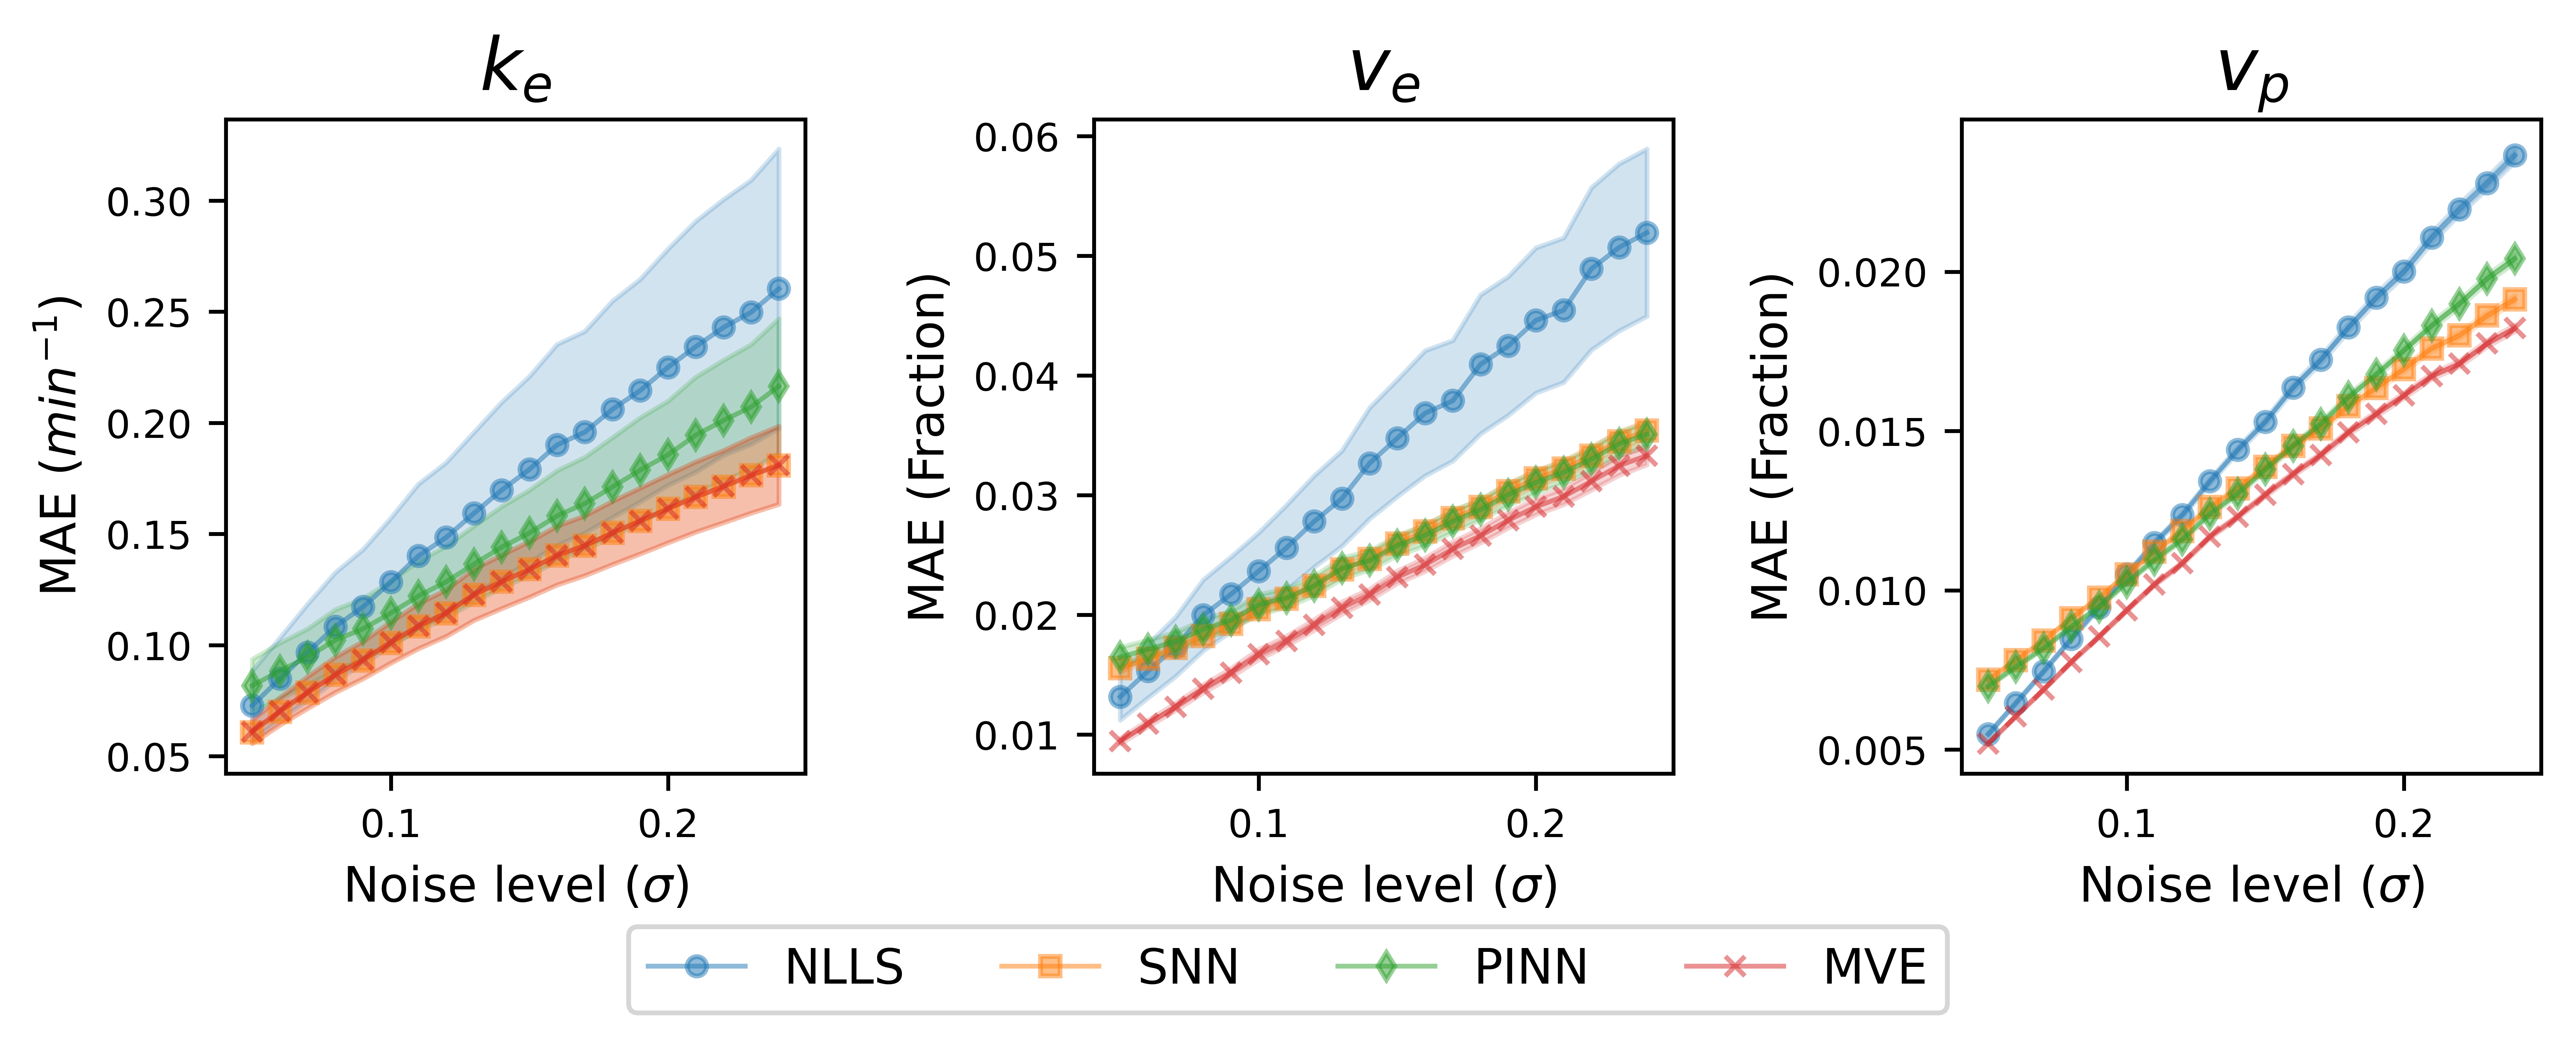

In [4]:
mode = "normal"
model_paths = {
    "NLLS" : "output/normal/nlls",
    "SNN" : "output/normal/snn_dcenet_1/predictions",
    "PINN" : "output/normal/pinn_ph_dcenet_0/predictions",
    "MVE" : "output/normal/mve_snn_dcenet_0/predictions",
    # "MVE (pi)" : "output/normal/mve_pinn_dcenet_3/predictions",
    # "MVE (ens)" : "output/normal/mve_snn_dcenet_ens/predictions",
    # "mve (pi, ens)" : "output/normal/mve_pinn_dcenet_ens/predictions",
}

data = np.load("data/sim/normal/test.npz")

fig = errors_by_noise(model_paths, data, mode)
if save:
    fig.savefig(f"{outpath}/aleatoric/errors_by_noise_{mode}.jpg", format="jpg", dpi=1000)

Reconstruction errors of ood models:
NLLS: 0.1126 (std: 0.0461)
PINN (ens): 0.1154 (std: 0.0459)
MVE (ens): 0.1187 (std: 0.0487)
Wilcoxon test between reconstruction errors:
Wilcoxon NLLS vs PINN (ens): 0.0
T-test NLLS vs PINN (ens): 0.0
Wilcoxon NLLS vs MVE (ens): 0.0
T-test NLLS vs MVE (ens): 0.0
Wilcoxon PINN (ens) vs NLLS: 0.0
T-test PINN (ens) vs NLLS: 0.0
Wilcoxon PINN (ens) vs MVE (ens): 0.0
T-test PINN (ens) vs MVE (ens): 0.0
Wilcoxon MVE (ens) vs NLLS: 0.0
T-test MVE (ens) vs NLLS: 0.0
Wilcoxon MVE (ens) vs PINN (ens): 0.0
T-test MVE (ens) vs PINN (ens): 0.0


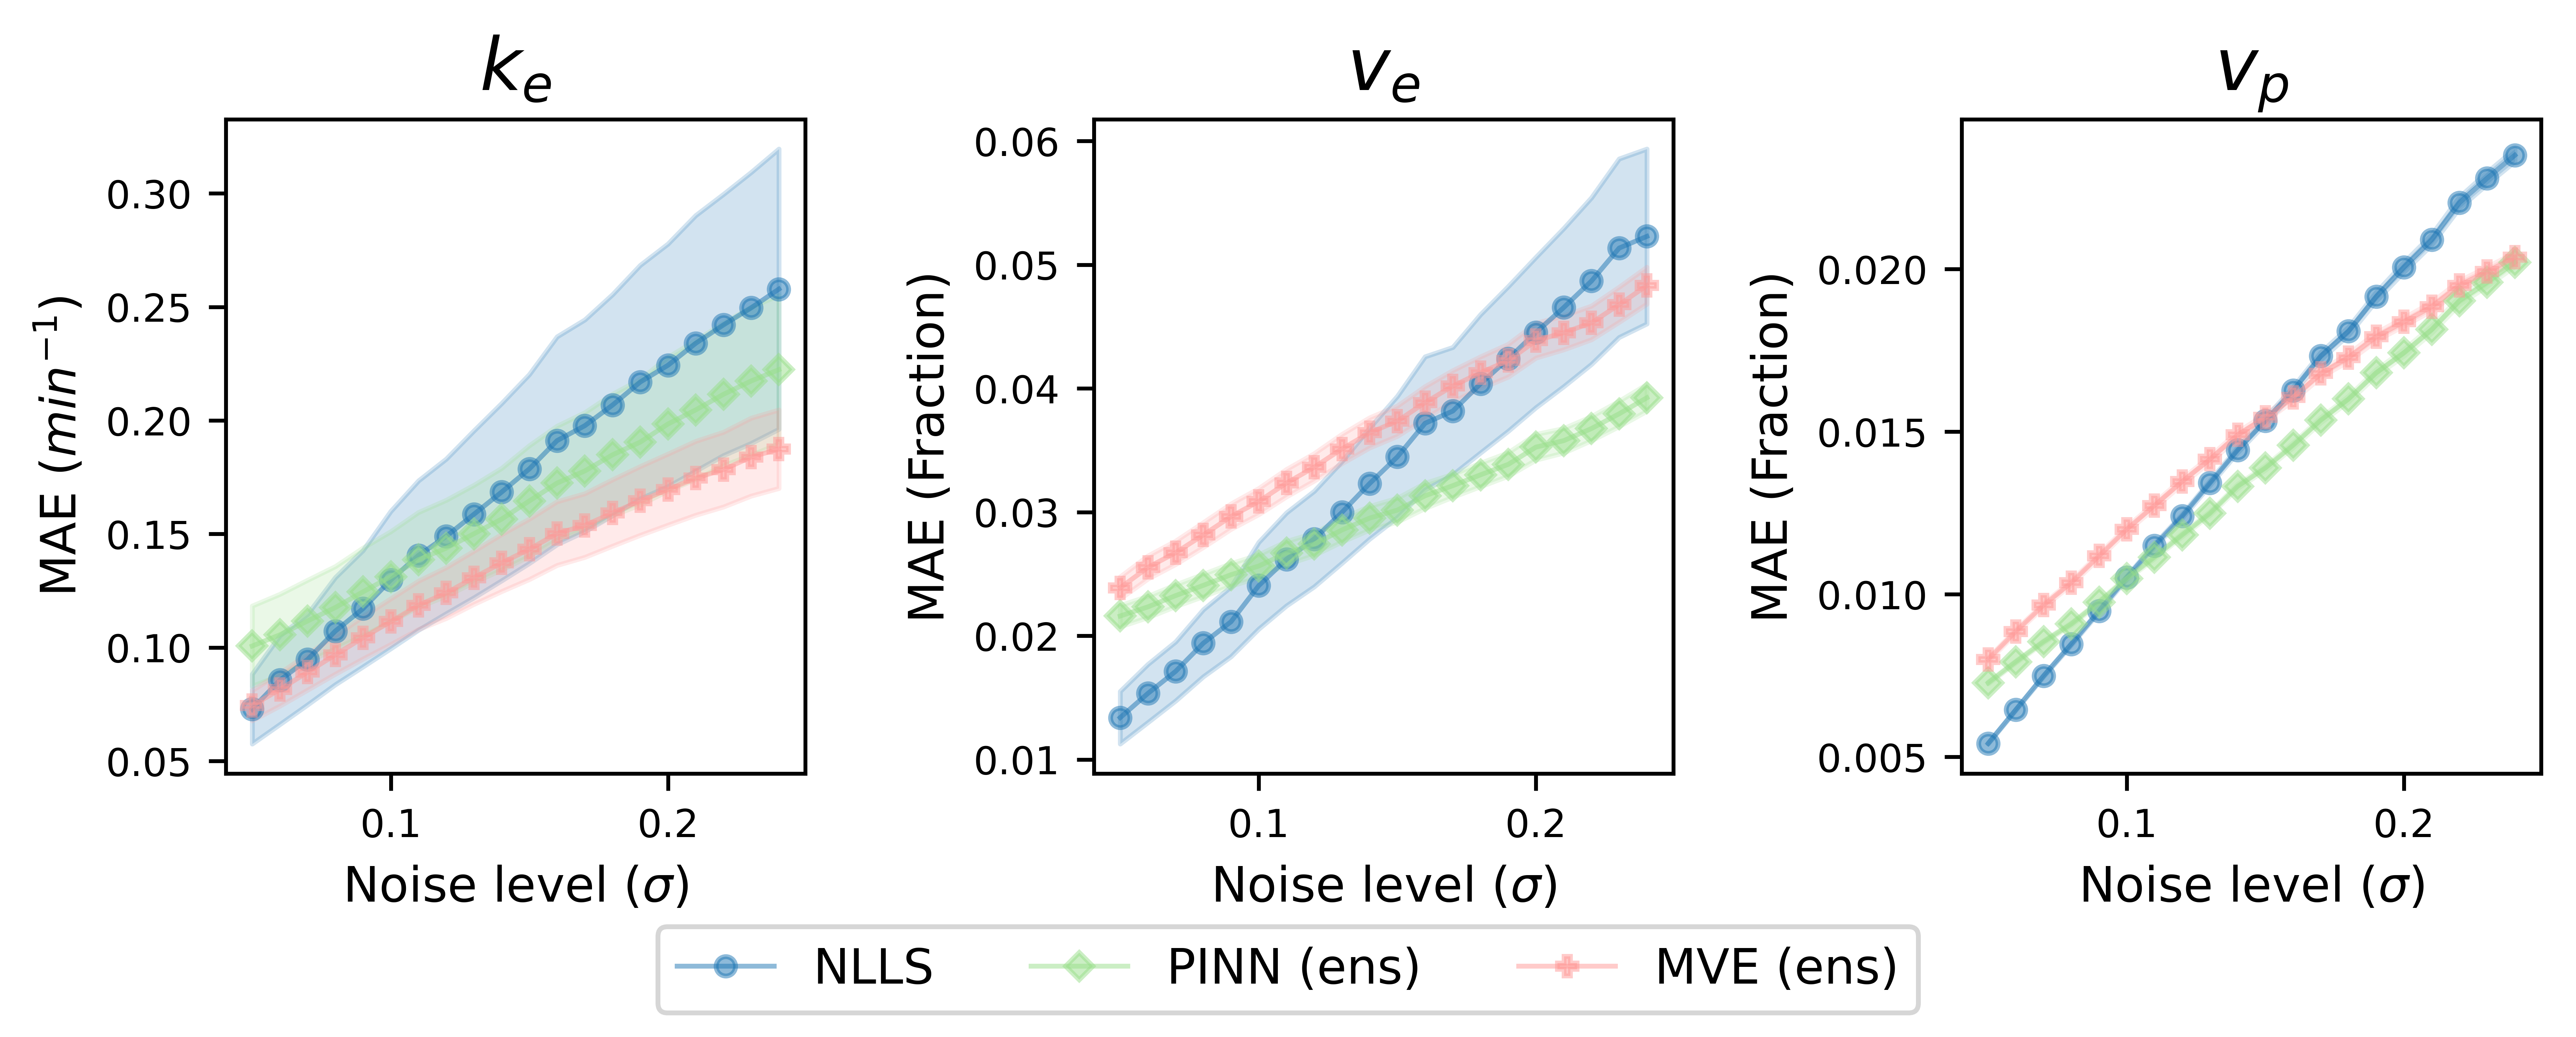

In [5]:
mode = "ood"
model_paths = {
    "NLLS" : "output/ood/nlls",
    # "SNN" : "output/ood/snn_dcenet_3/predictions",
    # "PINN" : "output/ood/pinn_ph_dcenet_3/predictions",
    "PINN (ens)" : "output/ood/pinn_ph_dcenet_ens/predictions",
    # "MVE" : "output/ood/mve_snn_dcenet_4/predictions",
    "MVE (ens)" : "output/ood/mve_snn_dcenet_ens/predictions",
    # "MVE (pi)" : "output/ood/mve_pinn_dcenet_3/predictions",
    # "MVE (pi, ens)" : "output/ood/mve_pinn_dcenet_ens/predictions",
}

data = np.load("data/sim/normal_ood/test.npz")

fig = errors_by_noise(model_paths, data, mode)
if save:
    fig.savefig(f"output/vis_report_final/epistemic/errors_by_noise_{mode}.jpg", format="jpg", dpi=1000)


Reconstruction errors of normal models:
NLLS: 0.1126 (std: 0.0462)
PINN: 0.1138 (std: 0.0458)
MVE: 0.1131 (std: 0.0463)
MVE (pi): 0.1139 (std: 0.0459)
Wilcoxon test between reconstruction errors:
Wilcoxon NLLS vs PINN: 0.0
T-test NLLS vs PINN: 4.593460422142082e-123
Wilcoxon NLLS vs MVE: 0.0
T-test NLLS vs MVE: 3.5606284564410657e-28
Wilcoxon NLLS vs MVE (pi): 0.0
T-test NLLS vs MVE (pi): 4.522310089544838e-134
Wilcoxon PINN vs NLLS: 0.0
T-test PINN vs NLLS: 4.593460422142082e-123
Wilcoxon PINN vs MVE: 0.0
T-test PINN vs MVE: 6.763883142290035e-36
Wilcoxon PINN vs MVE (pi): 0.0006459421296407782
T-test PINN vs MVE (pi): 0.28102837089930954
Wilcoxon MVE vs NLLS: 0.0
T-test MVE vs NLLS: 3.5606284564410657e-28
Wilcoxon MVE vs PINN: 0.0
T-test MVE vs PINN: 6.763883142290035e-36
Wilcoxon MVE vs MVE (pi): 0.0
T-test MVE vs MVE (pi): 6.288825388981714e-42
Wilcoxon MVE (pi) vs NLLS: 0.0
T-test MVE (pi) vs NLLS: 4.522310089544838e-134
Wilcoxon MVE (pi) vs PINN: 0.0006459421296407782
T-test MVE 

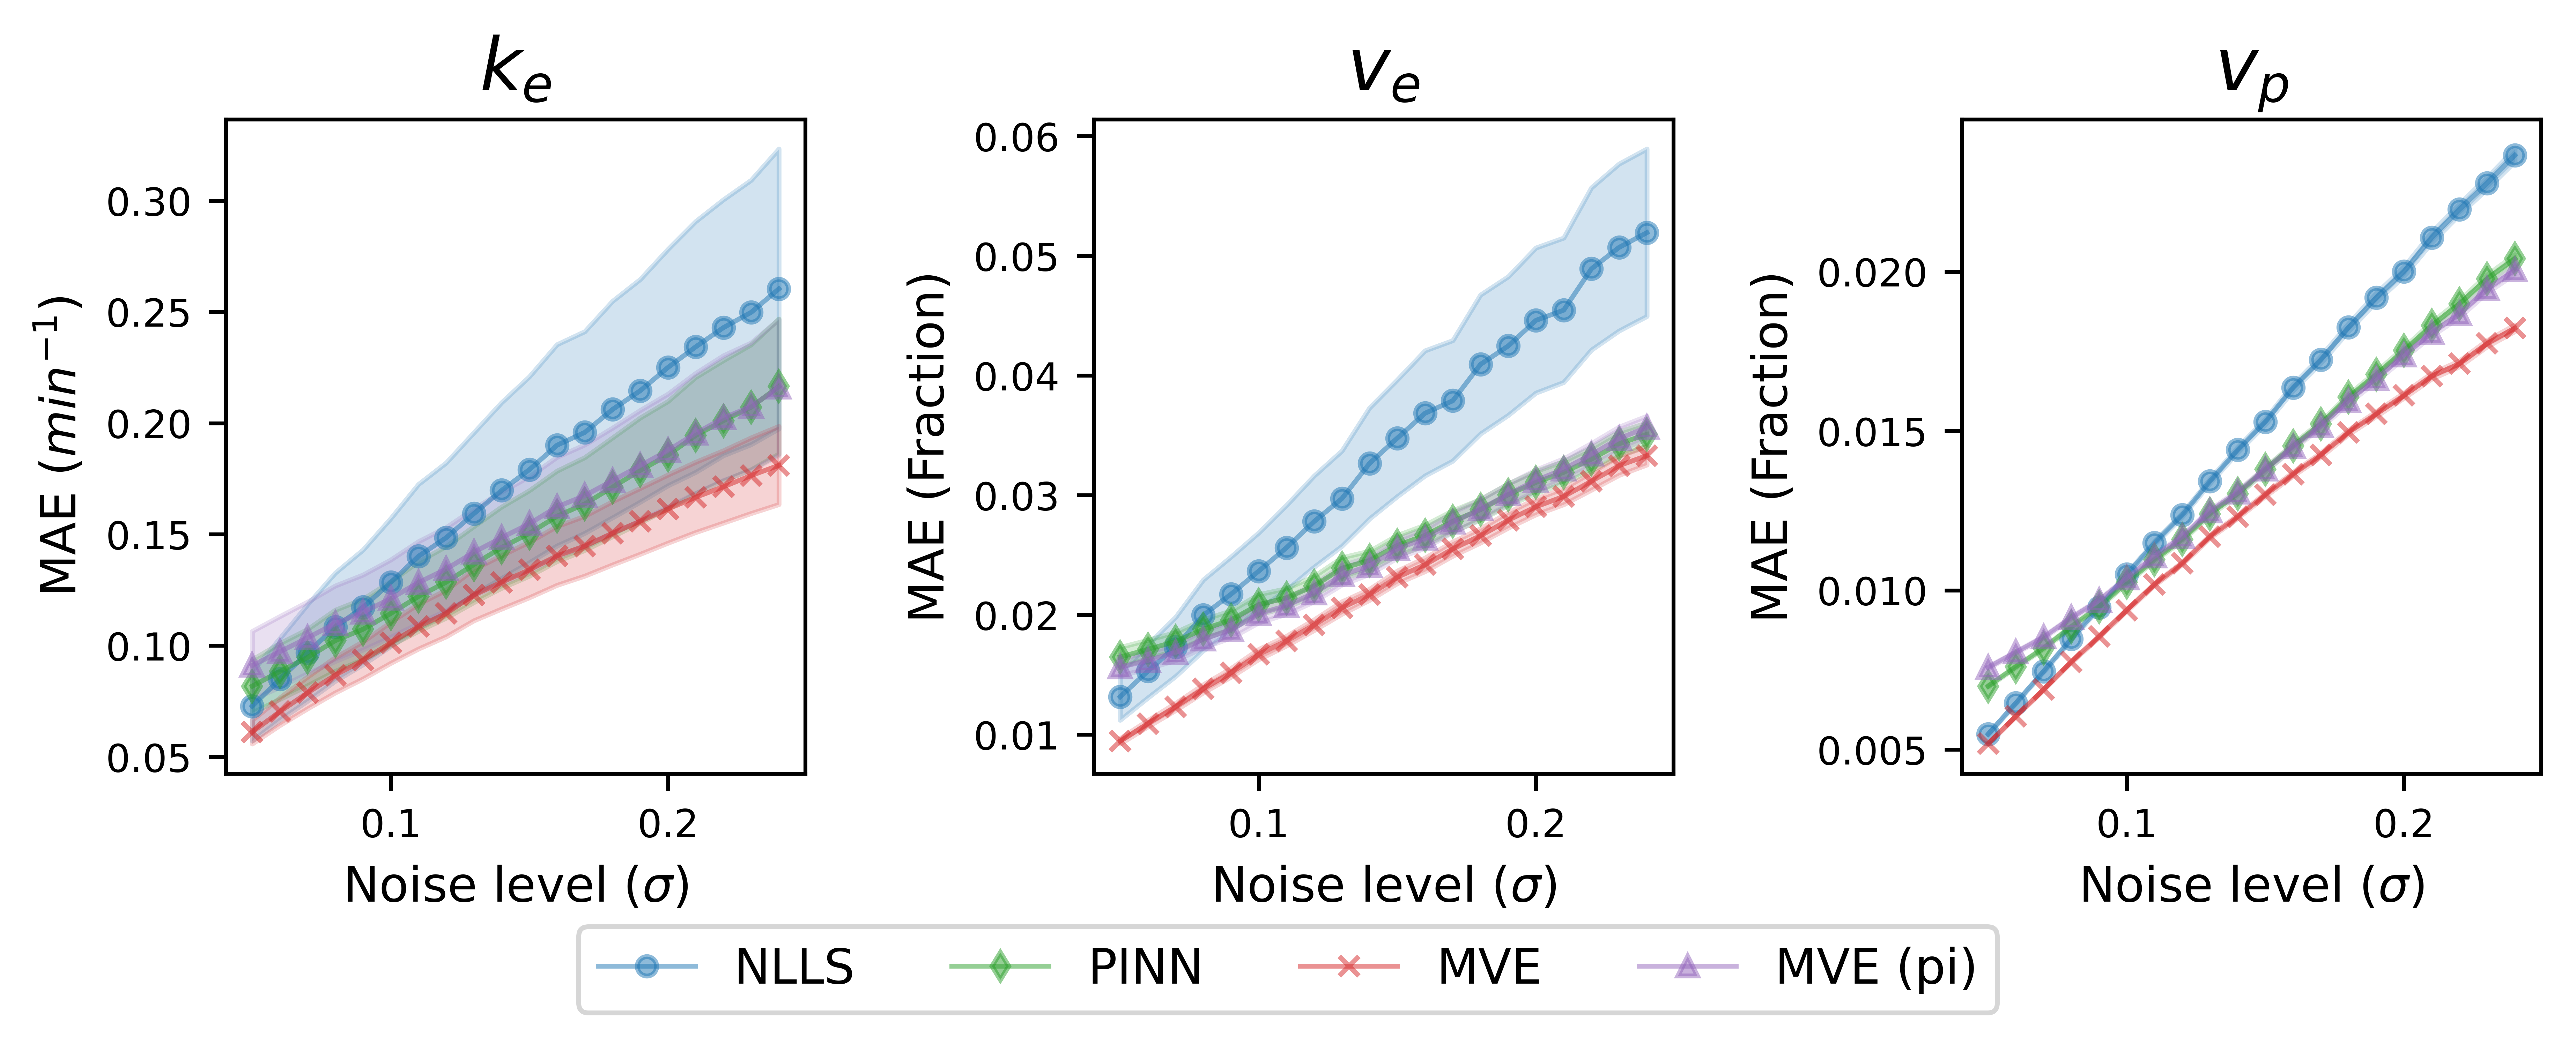

In [6]:
mode = "normal"
model_paths = {
    "NLLS" : "output/normal/nlls",
    # "SNN" : "output/normal/snn_dcenet_1/predictions",
    "PINN" : "output/normal/pinn_ph_dcenet_0/predictions",
    "MVE" : "output/normal/mve_snn_dcenet_0/predictions",
    "MVE (pi)" : "output/normal/mve_pinn_dcenet_3/predictions",
    # "MVE (ens)" : "output/normal/mve_snn_dcenet_ens/predictions",
    # "mve (pi, ens)" : "output/normal/mve_pinn_dcenet_ens/predictions",
}

data = np.load("data/sim/normal/test.npz")

fig = errors_by_noise(model_paths, data, mode)
if save:
    fig.savefig(f"output/vis_report_final/appendix/errors_by_noise_{mode}_pimve.jpg", format="jpg", dpi=1000)